Import all requirements and helper functions


In [1]:
# Turning ML Paper into usable code:
# Specifically "An Image Is Worth 16x16 Words"
# https://arxiv.org/abs/2010.11929

#Importing all torch libraries
try:
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions are not installed")



torch version: 2.2.2+cu118
torchvision version: 0.17.2+cu118


In [2]:
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms
from torchinfo import summary

from going_modular.going_modular import data_setup, engine
from helper_functions import download_data, set_seeds, plot_loss_curves

c:\Users\A-Man\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

Import Dataset and create paths to train and test data

In [4]:
# Get the Food Vision Mini Dataset
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path

[INFO] data\pizza_steak_sushi directory exists, skipping download.


WindowsPath('data/pizza_steak_sushi')

In [5]:
train_dir = image_path/"train"
test_dir = image_path/"test"
train_dir,test_dir

(WindowsPath('data/pizza_steak_sushi/train'),
 WindowsPath('data/pizza_steak_sushi/test'))

Create Dataloaders for train and test data

In [6]:
#Create Datasets and Dataloaders
from torchvision import transforms
from going_modular.going_modular import data_setup
IMG_SIZE = 224 # table 3

#transforms pipeline
manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE,IMG_SIZE)),
    transforms.ToTensor()
])

print(f"manual transforms: {manual_transforms}")

manual transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)


In [7]:
#create batch size, starting small
BATCH_SIZE = 32
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms,
    batch_size=BATCH_SIZE
) 

In [8]:
len(train_dataloader),len(test_dataloader),class_names

(8, 3, ['pizza', 'steak', 'sushi'])

In [9]:
#single image visualization
import random 
import numpy as np
import matplotlib.pyplot as plt

img_batch, label_batch = next(iter(train_dataloader))
img,label = img_batch[0],label_batch[0]

img.shape, label

(torch.Size([3, 224, 224]), tensor(1))

(-0.5, 223.5, 223.5, -0.5)

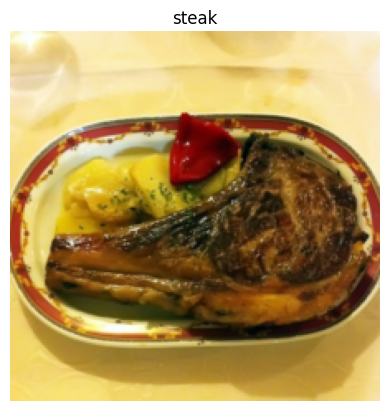

In [10]:
plt.imshow(img.permute(1,2,0))
plt.title(class_names[label])
plt.axis(False)

Recreating The Vision Transformer



### 3.1 ViT overview: pieces of the puzzle
* Figure 1: Visual overview of the architecture
* Four equations: math equations which define the functions of each layer/block
* Table 1/3: different hyperparameters for the architecture/training.
* Text
#### Figure 1
![](https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/08-vit-paper-figure-1-architecture-overview.png)
* Embedding = learnable representation (random numbers -> imrpovement over time)
* MLP = Multi Layer Perceptron
#### Four equations
![](https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/08-vit-paper-four-equations.png)
#### Table 1
![](https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/08-vit-paper-table-1.png)

\begin{aligned}
\mathbf{z}_0 & =\left[\mathbf{x}_{\text {class }} ; \mathbf{x}_p^1 \mathbf{E} ; \mathbf{x}_p^2 \mathbf{E} ; \cdots ; \mathbf{x}_p^N \mathbf{E}\right]+\mathbf{E}_{p o s}, & & \mathbf{E} \in \mathbb{R}^{\left(P^2, C\right) \times D}, \mathbf{E}_{\text {pos }} \in \mathbb{R}^{(N+1) \times D} \\
\mathbf{z}_{\ell}^{\prime} & =\operatorname{MSA}\left(\operatorname{LN}\left(\mathbf{z}_{\ell-1}\right)\right)+\mathbf{z}_{\ell-1}, & & \ell=1 \ldots L \\
\mathbf{z}_{\ell} & =\operatorname{MLP}\left(\operatorname{LN}\left(\mathbf{z}_{\ell}^{\prime}\right)\right)+\mathbf{z}_{\ell}^{\prime}, & & \ell=1 \ldots L \\
\mathbf{y} & =\operatorname{LN}\left(\mathbf{z}_L^0\right) & &
\end{aligned}

In [11]:
#Recreating The Vision Transformer Architecture
'''
Eq.1 in Pseudocode

x_input = [class_token, img_patch_1, img_patch_2,...,img_patch_N] +
[class_token_pos, image_patch_1_pos, image_patch_2_pos,...,image_patch_N_pos]

Eq.2 in Pseudocode = MSA (Multihead Self Attention) block
x_output_MSA_block = MSA_layer(LN_layer(x_input)) + x_input

Eq.3 in Pseudocode = MLP (Multi Layer Perseptron) block
x_output_MLP_block = MLP_Layer(LN_layer(x_output_MSA_block)) + x_output_MSA_block

Eq.4 in Pseudocode:
y_output = linear_layer(LN_layer(x_output_MLP_block))

''' 

'\nEq.1 in Pseudocode\n\nx_input = [class_token, img_patch_1, img_patch_2,...,img_patch_N] +\n[class_token_pos, image_patch_1_pos, image_patch_2_pos,...,image_patch_N_pos]\n\nEq.2 in Pseudocode = MSA (Multihead Self Attention) block\nx_output_MSA_block = MSA_layer(LN_layer(x_input)) + x_input\n\nEq.3 in Pseudocode = MLP (Multi Layer Perseptron) block\nx_output_MLP_block = MLP_Layer(LN_layer(x_output_MSA_block)) + x_output_MSA_block\n\nEq.4 in Pseudocode:\ny_output = linear_layer(LN_layer(x_output_MLP_block))\n\n'

In [12]:
# Equation 1: Split data into patches, creating the class, pos, and patch embeddings
#input shape: (224,224,3) - single img H * W * C

#H = height
#W = width
#C = color channels
#N = Number patches // N = H*W/P^2 
#P = patch size
#D = constant latent vec size = embedding dim (See Table 1)

#output shape: N * (P^2 * C)
height = 224
width = 224
color = 3
patch_size = 16
N = int((height*width)/(patch_size**2))
print(f"Number Patches: {N}")
output_shape = int(N * (patch_size**2 * color))
print(f"Output Shape: {output_shape}")

Number Patches: 196
Output Shape: 150528


In [13]:
#input shape
embedding_layer_input_shape = (height,width,color)
#output shape
embedding_layer_output_shape = (N,patch_size**2 * color)
print(f"Input Shape (2D image): {embedding_layer_input_shape}")
print(f"Output Shape (1D sequence of patches): {embedding_layer_output_shape}") #number_patches,embedding_dimension



Input Shape (2D image): (224, 224, 3)
Output Shape (1D sequence of patches): (196, 768)


(-0.5, 223.5, 223.5, -0.5)

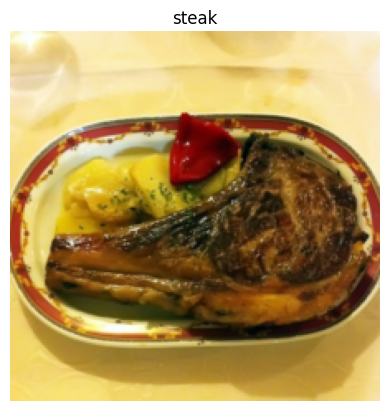

In [14]:
#Turning a single image into patches
plt.imshow(img.permute(1,2,0))
plt.title(class_names[label])
plt.axis(False)

In [15]:
img.shape

torch.Size([3, 224, 224])

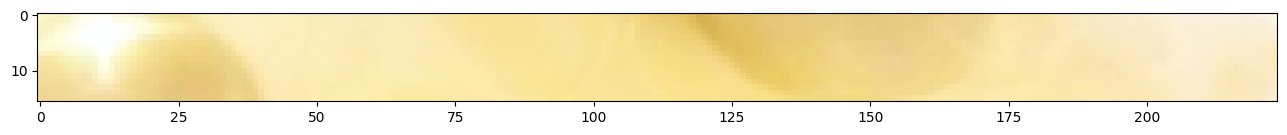

In [16]:
#Get the top row
image_permuted = img.permute(1,2,0)#HWC

patch_size = 16
plt.figure(figsize=(patch_size,patch_size))
plt.imshow(image_permuted[:patch_size,:,:])

Text(0.5, 0.98, 'steak -> Patchified')

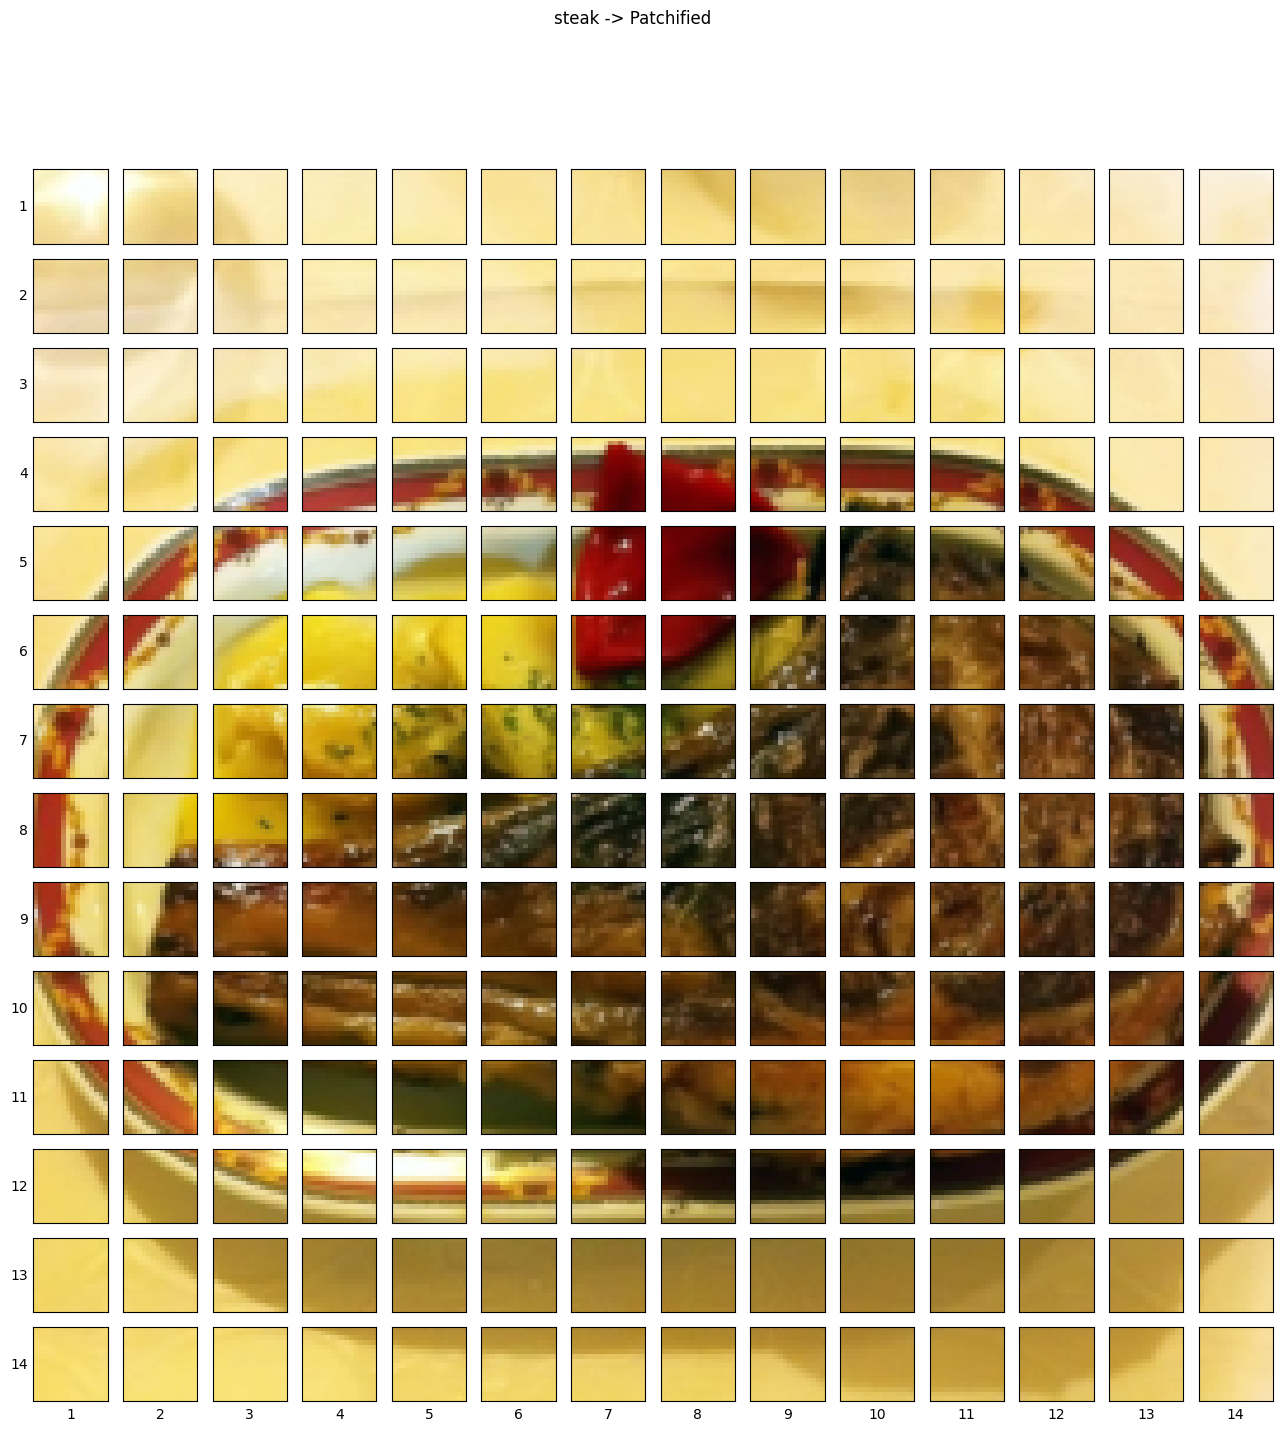

In [17]:
#Plot top row as a row of patches
img_size = 224
patch_size = 16
num_patches = img_size/patch_size 
num_patches
assert img_size % patch_size == 0, "Image size must be divisible by patch size"

#Create a series of subplots
fig,ax = plt.subplots(nrows=img_size // patch_size,
                      ncols=img_size // patch_size,
                       sharex=True,
                       sharey=True,
                       figsize=(patch_size,patch_size))

#loop through H and W
for i,patch_height in enumerate(range(0,img_size,patch_size)): #height
    for j,patch_width in enumerate(range(0,img_size,patch_size)): #width
        #plotting image on different axes
        ax[i,j].imshow(image_permuted[patch_height:patch_height+patch_size,
                                      patch_width:patch_width+patch_size,:])
        ax[i,j].set_ylabel(i+1,rotation="horizontal",
                           horizontalalignment="right",
                           verticalalignment="center")
        ax[i,j].set_xlabel(j+1)
        ax[i,j].set_xticks([])
        ax[i,j].set_yticks([])
        ax[i,j].label_outer()
fig.suptitle(f"{class_names[label]} -> Patchified")

In [18]:
#flatten image into 1d and embeddings using torch nn conv2d
from torch import nn
patch_size = 16
conv2d = nn.Conv2d(in_channels=3, #for color images
                   out_channels=768, #size from Table 1
                   kernel_size=patch_size,
                   stride= patch_size,
                   padding=0)
conv2d

Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))

(-0.5, 223.5, 223.5, -0.5)

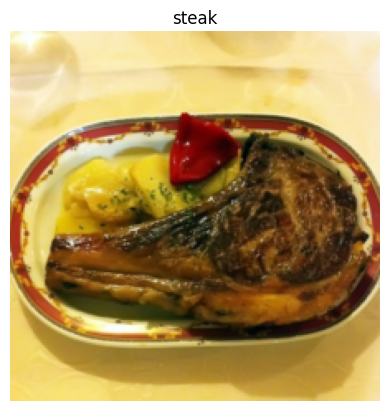

In [19]:
plt.imshow(img.permute(1,2,0))
plt.title(class_names[label])
plt.axis(False)

In [20]:
#pass img through conv2d
img_conv2d = conv2d(img.unsqueeze(0))# adding batch dimension
print(img_conv2d.shape)

torch.Size([1, 768, 14, 14])


Showing random conv feature maps from indexes: [489, 250, 427, 528, 53]


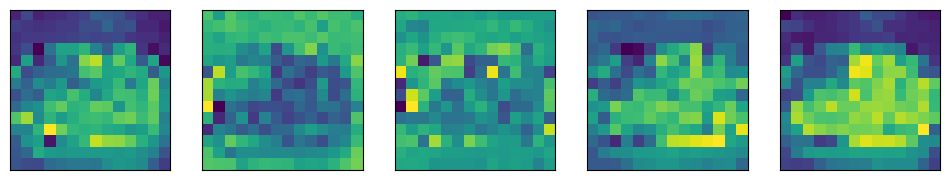

In [21]:
#image is now in the correct representation that the paper needs
# now we flatten the embeddings into a sequence
torch.Size([1,768,14,14])#[batch_size,embedding_dim,feature_map_height,feature_map_width]
import random
rand_idxs = random.sample(range(0,758),k=5)
print(f"Showing random conv feature maps from indexes: {rand_idxs}")

#create plot
fig,ax = plt.subplots(nrows=1,ncols=5,figsize=(12,12))

for i, idx in enumerate(rand_idxs):
    image_conv_feature_map = img_conv2d[:,idx,:,:]# index on the output tensor of c2d layer
    ax[i].imshow(image_conv_feature_map.squeeze().detach().numpy())
    ax[i].set(xticklabels=[],yticklabels=[], xticks=[], yticks=[])


In [22]:
#Get a single feature map in tensor form
single_feature_map = img_conv2d[:,0,:,:]
single_feature_map,single_feature_map.requires_grad

(tensor([[[-0.4096, -0.4613, -0.4146, -0.4602, -0.4597, -0.4687, -0.4511,
           -0.4318, -0.4458, -0.4174, -0.4389, -0.4339, -0.4337, -0.4386],
          [-0.4453, -0.4347, -0.4404, -0.4442, -0.4496, -0.4677, -0.5072,
           -0.4893, -0.4904, -0.4556, -0.4640, -0.4311, -0.4400, -0.4217],
          [-0.4017, -0.4526, -0.4084, -0.4599, -0.4730, -0.4807, -0.4673,
           -0.4713, -0.4785, -0.4751, -0.4752, -0.4450, -0.4579, -0.4295],
          [-0.4481, -0.4950, -0.4969, -0.2771, -0.3963, -0.3185, -0.5240,
           -0.2387, -0.2216, -0.3484, -0.4389, -0.4775, -0.3796, -0.4354],
          [-0.4838, -0.3698, -0.2363, -0.3730, -0.4615, -0.3641,  0.0366,
            0.0119,  0.0150, -0.2117, -0.3383, -0.1980, -0.1982, -0.3430],
          [-0.3106, -0.3913, -0.4682, -0.5411, -0.5264, -0.4822, -0.1349,
           -0.2067, -0.0548, -0.1075, -0.1719, -0.1577, -0.2659, -0.4089],
          [-0.3726, -0.4261, -0.5268, -0.4189, -0.2944, -0.2175, -0.2852,
           -0.1057, -0.0803, -0.

In [23]:
#Time to flatten the feature map
from torch import nn
print(img_conv2d.shape)
#img_conv2d_flat = torch.flatten(img_conv2d,2,3)
flatten = nn.Flatten(start_dim=2,end_dim=3)
flatten(img_conv2d).shape



torch.Size([1, 768, 14, 14])


torch.Size([1, 768, 196])

Original Image Shape: torch.Size([3, 224, 224])
Feature Map: torch.Size([1, 768, 14, 14])
Flattened Feature Map Shape: torch.Size([1, 768, 196])
Permuted Shape: torch.Size([1, 196, 768])


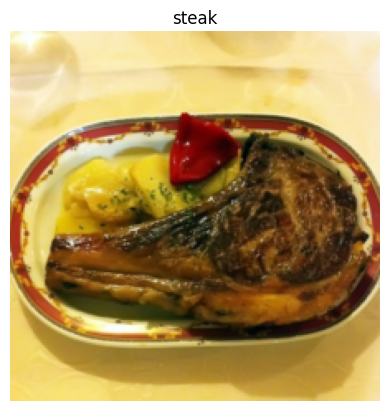

In [24]:
#Put everything together
plt.imshow(img.permute(1,2,0))
plt.title(class_names[label])
plt.axis(False)
print(f"Original Image Shape: {img.shape}")

#Turn into Feature Maps
image_out_of_conv = conv2d(img.unsqueeze(0))#add batch dim
print(f"Feature Map: {image_out_of_conv.shape}")

#Flatten
img_out_conv_flat = flatten(image_out_of_conv)
img_out_of_conv_flattened_permuted = img_out_conv_flat.permute(0,2,1)
print(f"Flattened Feature Map Shape: {img_out_conv_flat.shape}")
print(f"Permuted Shape: {img_out_of_conv_flattened_permuted.shape}")#batch_size, num_patches,embed_dim 

In [25]:
single_flat_feature_map = img_out_of_conv_flattened_permuted[:,:,0]
single_flat_feature_map

tensor([[-0.4096, -0.4613, -0.4146, -0.4602, -0.4597, -0.4687, -0.4511, -0.4318,
         -0.4458, -0.4174, -0.4389, -0.4339, -0.4337, -0.4386, -0.4453, -0.4347,
         -0.4404, -0.4442, -0.4496, -0.4677, -0.5072, -0.4893, -0.4904, -0.4556,
         -0.4640, -0.4311, -0.4400, -0.4217, -0.4017, -0.4526, -0.4084, -0.4599,
         -0.4730, -0.4807, -0.4673, -0.4713, -0.4785, -0.4751, -0.4752, -0.4450,
         -0.4579, -0.4295, -0.4481, -0.4950, -0.4969, -0.2771, -0.3963, -0.3185,
         -0.5240, -0.2387, -0.2216, -0.3484, -0.4389, -0.4775, -0.3796, -0.4354,
         -0.4838, -0.3698, -0.2363, -0.3730, -0.4615, -0.3641,  0.0366,  0.0119,
          0.0150, -0.2117, -0.3383, -0.1980, -0.1982, -0.3430, -0.3106, -0.3913,
         -0.4682, -0.5411, -0.5264, -0.4822, -0.1349, -0.2067, -0.0548, -0.1075,
         -0.1719, -0.1577, -0.2659, -0.4089, -0.3726, -0.4261, -0.5268, -0.4189,
         -0.2944, -0.2175, -0.2852, -0.1057, -0.0803, -0.1501, -0.1184, -0.1667,
         -0.1025, -0.3086, -

(-0.5, 195.5, 0.5, -0.5)

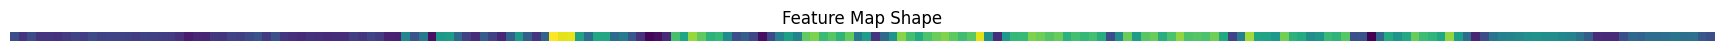

In [26]:
#plot flatenned feature map visually
plt.figure(figsize=(22,22))
plt.imshow(single_flat_feature_map.detach().numpy())
plt.title(f"Feature Map Shape")
plt.axis(False)

In [27]:
#turning the VIT patch embedding layer into a pytorch module
'''
1.) create class called PatchEmbedding
2.) Init with hyper params
3.) Create layer to turn img into embeeding using nn.Conv2d()
4.) Create layer to flatten the feature maps
5.) Define a forward method
6.) Check output shape 
'''
class PatchEmbedding(nn.Module):
    def __init__(self,
                 in_channels: int= 3,
                 patch_size: int= 16,
                 embedding_dim: int=768):
        super().__init__()
        self.patch_size = patch_size

        #turn image to embedding patches using conv2d
        self.patcher = nn.Conv2d(in_channels=in_channels, #for color images
                    out_channels=embedding_dim, #size from Table 1
                    kernel_size=patch_size,
                    stride=patch_size,
                    padding=0)
        
        #flatten the feature maps of the patcher layer
        self.flatten = nn.Flatten(start_dim=2,end_dim=3)

    #define forward method
    def forward(self,x):
        image_res = x.shape[-1]
        #create assert for correct image resolution
        assert image_res % patch_size == 0, f"Input IMG size must be divisible by patch size. Image Shape: {image_res}, Patch Size: {self.patch_size} "

        #perform foward pass
        x_patched = self.patcher(x)
        x_flattened = self.flatten(x_patched)

        #re-order dimensions
        x_reordered = x_flattened.permute(0,2,1)
        return x_reordered

In [28]:
set_seeds()
#create instance of patch to test w/ default vals
patchify = PatchEmbedding()
print(f"Test Image Size: {img.unsqueeze(0).shape}")
patch_embedded_img = patchify(img.unsqueeze(0))
print(f"Output patch embedding shape: {patch_embedded_img.shape}")#batch_size, num_patches,embed_dim 

Test Image Size: torch.Size([1, 3, 224, 224])
Output patch embedding shape: torch.Size([1, 196, 768])


In [29]:
rand_img_tensor = torch.rand(1,3,224,224)
#rand_img_tensor_bad = torch.rand(1,3,250,250)
patchify(rand_img_tensor)

tensor([[[-0.6593,  0.0912, -0.1765,  ...,  0.2075, -0.2554,  0.1557],
         [-0.4664,  0.2626, -0.1843,  ..., -0.0550, -0.1587,  0.1954],
         [-0.4906,  0.1833, -0.1601,  ...,  0.6322, -0.1585,  0.0585],
         ...,
         [-0.6404,  0.1462, -0.3884,  ...,  0.5681, -0.1871,  0.4515],
         [-0.5264,  0.2209, -0.1268,  ...,  0.2466, -0.1717,  0.0054],
         [-0.3889, -0.0037, -0.2184,  ...,  0.1711,  0.0484,  0.0425]]],
       grad_fn=<PermuteBackward0>)

In [30]:
patch_embedded_img.shape

torch.Size([1, 196, 768])

In [31]:
#Pre-append a learnable class token to the start of the patch embedding
#get bacth size and embedding dim
batch_size = patch_embedded_img.shape[0]
embedding_dim = patch_embedded_img.shape[-1]
batch_size,embedding_dim

(1, 768)

In [32]:
#Create class token embedding
class_token = nn.Parameter(torch.randn(batch_size,1,embedding_dim),
                           requires_grad= True)
class_token

Parameter containing:
tensor([[[-4.0634e-02, -5.1703e-01, -3.4886e-01,  5.3415e-01, -1.6016e+00,
          -8.8163e-01, -9.7648e-01,  1.0457e+00, -6.1893e-01, -2.8003e-01,
           1.0170e+00,  9.8506e-03, -3.5316e-01,  1.5248e-01,  3.9839e-02,
          -1.3422e-01,  6.8179e-01, -1.6287e+00, -6.4307e-01, -2.1524e+00,
          -1.0911e+00, -6.7105e-02,  7.1738e-01,  2.6903e-01,  1.4509e+00,
           8.0634e-01, -1.4708e+00, -6.8491e-01, -3.1017e-01,  3.8224e-01,
           1.8265e+00, -7.1812e-01,  1.0602e+00, -2.3947e-01,  1.3768e+00,
           6.9402e-01, -1.6403e-01, -3.5622e-01,  9.3032e-01, -1.0700e+00,
           7.4409e-01,  3.3989e-01,  6.8426e-01,  6.7231e-01,  1.4753e+00,
           8.2274e-01, -4.6872e-01,  5.4074e-01,  1.9531e-01, -9.2303e-01,
          -1.2160e+00,  1.4706e+00,  1.1645e+00, -1.5053e+00,  4.5479e-01,
           1.2067e+00,  4.6738e-01, -6.2192e-01, -6.2679e-03,  2.0897e+00,
          -9.8682e-01, -8.1428e-01, -4.3977e-01, -6.4792e-01,  3.3320e-02,
   

In [33]:
class_token.shape

torch.Size([1, 1, 768])

In [34]:
#add class token embedding to front of patch embedding
patch_embedded_img_w_class_embed = torch.cat((class_token,patch_embedded_img),
                                             dim= 1) # num patches dim
patch_embedded_img_w_class_embed.shape

torch.Size([1, 197, 768])

In [35]:
#create patch position embedding

#number of patches equation
number_of_patches = int((height*width)/patch_size**2)
#get the embedding dimension 
embedding_dim = patch_embedded_img_w_class_embed.shape[-1]
#Create the learnable 1D position embedding
pos_embedding = nn.Parameter(torch.ones(1,
                                        number_of_patches+1,
                                        embedding_dim,
                                        requires_grad= True))
pos_embedding,pos_embedding.shape

(Parameter containing:
 tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]]], requires_grad=True),
 torch.Size([1, 197, 768]))

In [36]:
#Add the position embedding to the patch and class token embedding
patch_and_pos_embedding = patch_embedded_img_w_class_embed + pos_embedding
print(patch_and_pos_embedding)
print(f"Patch and Position embedding shape: {patch_and_pos_embedding.shape}")

tensor([[[ 0.9594,  0.4830,  0.6511,  ...,  0.5078,  1.3503,  2.3471],
         [-0.0456,  1.2780,  0.8700,  ...,  1.7144,  0.4790,  1.3445],
         [ 0.1195,  1.1685,  0.8861,  ...,  1.6171,  0.4617,  1.3487],
         ...,
         [ 0.2993,  1.1617,  0.7900,  ...,  1.4558,  0.6969,  1.2626],
         [ 0.2251,  1.1918,  0.7797,  ...,  1.4947,  0.6685,  1.2646],
         [ 0.0918,  1.2509,  0.7482,  ...,  1.5959,  0.6061,  1.3173]]],
       grad_fn=<AddBackward0>)
Patch and Position embedding shape: torch.Size([1, 197, 768])


In [37]:
#Putting it all together
set_seeds()
patch_size = 16

# Print shapes of original image, and get dims
print(f"Image Tensor Shape: {img.shape}")
h,w = img.shape[1],img.shape[2] #height,width

# Get image tensor and add batch dimension
x = img.unsqueeze(0)
print(f"Input Image Shape: {x.shape}")

# Create class embedding layer
patch_embedding_layer = PatchEmbedding(in_channels=3,
                                       patch_size=patch_size,
                                       embedding_dim=768)

#Pass image through patch embedding layer
patch_embedding = patch_embedding_layer(x)
print(f"Patch Embedding Shape: {patch_embedding.shape}")

#create class token embedding
batch_size = patch_embedding.shape[0]
embedding_dim = patch_embedding.shape[-1]
class_token = nn.Parameter(torch.randn(batch_size,
                                       1,
                                       embedding_dim), requires_grad= True)
print(f"Class Token Embedding Shape: {class_token.shape}")

#prepend the class token to the patch embedding
patch_embedding_class_token = torch.cat((class_token,patch_embedding),dim=1)
print(f"Patch Embedding Plus Class Token Shape: {patch_embedding_class_token.shape}")

#create posititon embedding
num_patches = int((h*w)/(patch_size**2))
pos_embedding = nn.Parameter(torch.randn(1,
                                         num_patches+1,
                                         embedding_dim), requires_grad= True)

# Add pos embedding to to patch + class token
patch_pos_embedding = patch_embedding_class_token + pos_embedding
print(f"Patch + Pos Embedding Shape: {patch_pos_embedding.shape}")




Image Tensor Shape: torch.Size([3, 224, 224])
Input Image Shape: torch.Size([1, 3, 224, 224])
Patch Embedding Shape: torch.Size([1, 196, 768])
Class Token Embedding Shape: torch.Size([1, 1, 768])
Patch Embedding Plus Class Token Shape: torch.Size([1, 197, 768])
Patch + Pos Embedding Shape: torch.Size([1, 197, 768])


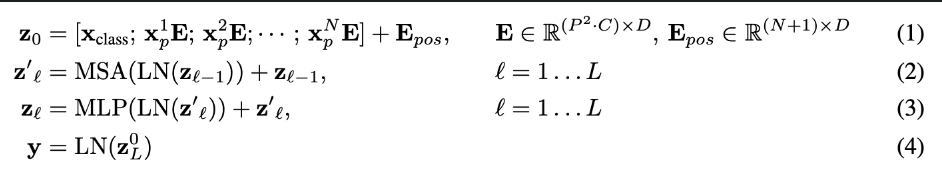

In [38]:
# Equation 2 MSA Block
class MultiHeadSelfAttentionBlock(nn.Module):
    def __init__(self,
                 embedding_dim: int=768,
                 num_heads: int=12, # Heads from table 1
                 attn_dropout: int=0):
        
        super().__init__()
        
        #create norm layer
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)

        #create multihead attention layer (MSA)
        self.multihead_attn = nn.MultiheadAttention(embed_dim=embedding_dim,
                                                    num_heads=num_heads,
                                                    dropout=attn_dropout,
                                                    batch_first=True)#is the batch first?(b,nump,embed_dim)
        
    def forward(self,x):
        l_norm = self.layer_norm(x)
        attn_output,_ = self.multihead_attn(query= x,
                                            key= x,
                                            value= x,
                                            need_weights= False)
        return attn_output


In [39]:
multihead_self_attn_block = MultiHeadSelfAttentionBlock(embedding_dim=768,
                                                        num_heads=12,
                                                        attn_dropout=0)

patched_img_through_MSA_block = multihead_self_attn_block(patch_and_pos_embedding)
print(f"Input Shape of MSA Block: {patch_and_pos_embedding.shape}")
print(f"Input Shape of MSA Block: {patched_img_through_MSA_block.shape}")

Input Shape of MSA Block: torch.Size([1, 197, 768])
Input Shape of MSA Block: torch.Size([1, 197, 768])


In [40]:
patch_and_pos_embedding

tensor([[[ 0.9594,  0.4830,  0.6511,  ...,  0.5078,  1.3503,  2.3471],
         [-0.0456,  1.2780,  0.8700,  ...,  1.7144,  0.4790,  1.3445],
         [ 0.1195,  1.1685,  0.8861,  ...,  1.6171,  0.4617,  1.3487],
         ...,
         [ 0.2993,  1.1617,  0.7900,  ...,  1.4558,  0.6969,  1.2626],
         [ 0.2251,  1.1918,  0.7797,  ...,  1.4947,  0.6685,  1.2646],
         [ 0.0918,  1.2509,  0.7482,  ...,  1.5959,  0.6061,  1.3173]]],
       grad_fn=<AddBackward0>)

In [41]:
patched_img_through_MSA_block

tensor([[[ 0.4662,  0.2574, -0.7466,  ..., -0.4376, -0.1235, -0.3862],
         [ 0.4624,  0.2448, -0.7512,  ..., -0.4385, -0.1251, -0.3798],
         [ 0.4630,  0.2455, -0.7509,  ..., -0.4388, -0.1254, -0.3794],
         ...,
         [ 0.4637,  0.2472, -0.7502,  ..., -0.4385, -0.1260, -0.3799],
         [ 0.4630,  0.2464, -0.7505,  ..., -0.4386, -0.1257, -0.3796],
         [ 0.4629,  0.2455, -0.7509,  ..., -0.4387, -0.1253, -0.3796]]],
       grad_fn=<TransposeBackward0>)

In [42]:
#Creating MLP (Multi Layer Perceptron) Layer
#Use GeLU function
    
class MLPBlock(nn.Module):
    def __init__(self,
                 embedding_dim: int=768,
                 mlp_size: int=3072,
                 dropout: float=0.1):
        super().__init__()

        #norm layer first
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)

        #mlp layer after
        self.mlp_layer = nn.Sequential(
            nn.Linear(in_features=embedding_dim,
                      out_features=mlp_size),
            nn.GELU(),
            nn.Dropout(p=dropout),
            nn.Linear(in_features=mlp_size,out_features=embedding_dim),
            nn.Dropout(p=dropout)
        )
    def forward(self,x):
        norm = self.layer_norm(x)
        mlp = self.mlp_layer(norm)
        return mlp



In [43]:
#instance of MLP block
mlp_block = MLPBlock(embedding_dim=768,
                     mlp_size=3072,
                     dropout=0.1)
patched_img_through_mlp = mlp_block(patched_img_through_MSA_block)

In [44]:
print(f"OUTPUT OF MSA BLOCK: {patched_img_through_mlp}")
#values have changed

OUTPUT OF MSA BLOCK: tensor([[[-0.1834,  0.1191, -0.2932,  ...,  0.0853, -0.0000, -0.0134],
         [-0.0000, -0.0671, -0.0791,  ...,  0.1264, -0.2357, -0.1573],
         [-0.0773,  0.0439, -0.1275,  ...,  0.0714, -0.1455, -0.0593],
         ...,
         [-0.1288, -0.0250, -0.2051,  ...,  0.0988, -0.1808, -0.0739],
         [-0.2040,  0.0823, -0.2275,  ...,  0.1663, -0.1003, -0.0874],
         [-0.0724,  0.0944, -0.1842,  ...,  0.0242, -0.1497, -0.0759]]],
       grad_fn=<MulBackward0>)


In [45]:
# Create the Full Transformer Encoder
# Using alternating combos of MSA(eq2) and MLP(eq3)
# Plus residual connections between each block
# x_input -> MSA_block -> [MSA_block + x_input] -> MLP_block -> [MLP_block_output + MSA_block_output + x_input]->...
class TransformerEncoder(nn.Module):
    def __init__(self,
                 embedding_dim: int=768,
                 num_heads: int=12,
                 mlp_size: int=3072,
                 mlp_dropout: float=0.1,
                 attn_dropout: int=0
                 ):

        super().__init__()

        #create MSA block
        self.msa_block = MultiHeadSelfAttentionBlock(embedding_dim=embedding_dim,
                                                     num_heads=num_heads,
                                                     attn_dropout=attn_dropout)
        
        #create MLP block
        self.mlp_block = MLPBlock(embedding_dim=embedding_dim,
                                  mlp_size=mlp_size,
                                  dropout=mlp_dropout)

    def forward(self,x):
        x= self.msa_block(x) + x # + x is the residual connection
        x= self.mlp_block(x) + x # skip connection / res from eq3
        return x




In [46]:
#Create instance of transformerEncoder Block
trans_encode_block = TransformerEncoder()

#get torchinfor summary
summary(model=trans_encode_block,
        input_size=(1,197,768), #batch_size, num_patches, embedding_dim
        col_names=["input_size","output_size","num_params","trainable"],
        col_width=20,
        row_settings=["var_names"])

c:\Users\A-Man\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\activation.py:1196: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:263.)
  return torch._native_multi_head_attention(


Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoder (TransformerEncoder)            [1, 197, 768]        [1, 197, 768]        --                   True
├─MultiHeadSelfAttentionBlock (msa_block)          [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─MultiheadAttention (multihead_attn)         --                   [1, 197, 768]        2,362,368            True
├─MLPBlock (mlp_block)                             [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─Sequential (mlp_layer)                      [1, 197, 768]        [1, 197, 768]        --                   True
│    │    └─Linear (0)                     

In [47]:
# Create a Transformer Enconder Layer with in-build PT layers
encoder_layer = nn.TransformerEncoderLayer(d_model= 768,
                                           nhead= 12,
                                           dim_feedforward= 3072,
                                           dropout= 0.1,
                                           activation="gelu",
                                           batch_first=True,
                                           norm_first=True)
encoder_layer


TransformerEncoderLayer(
  (self_attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
  )
  (linear1): Linear(in_features=768, out_features=3072, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (linear2): Linear(in_features=3072, out_features=768, bias=True)
  (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (dropout1): Dropout(p=0.1, inplace=False)
  (dropout2): Dropout(p=0.1, inplace=False)
)

In [48]:
#get torchinfor summary
summary(model=encoder_layer,
        input_size=(1,197,768), #batch_size, num_patches, embedding_dim
        col_names=["input_size","output_size","num_params","trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderLayer (TransformerEncoderLayer)  [1, 197, 768]        [1, 197, 768]        7,087,872            True
Total params: 7,087,872
Trainable params: 7,087,872
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0
Input size (MB): 0.61
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.61

In [49]:
#Put everything together to Make VIT
#Create VIT Class
class ViT(nn.Module):
    def __init__(self,
                 img_size:int=224,
                 in_channels: int=3,
                 patch_size: int=16,
                 num_trans_layers:int=12,
                 embedding_dim:int=768,
                 mlp_size: int=3072,
                 num_heads: int=12,
                 attn_dropout: int=0,
                 ml_dropout: float=0.1,
                 embedding_dropout:float=0.1,
                 num_classes:int=1000):
        super().__init__()

        #assert img size is / by patch
        assert img_size % patch_size == 0, f"Image size must be divisible by patch size, image: {img_size}, patch: {patch_size}"

        #calcualte num patches
        self.num_patches = (img_size **2) // patch_size**2

        #create learnable class embedding
        self.class_embedding = nn.Parameter(data=torch.randn(1,1,embedding_dim), requires_grad=True)

        #create position embedding
        self.pos_embedding = nn.Parameter(data=torch.randn(1,self.num_patches+1,embedding_dim))

        #create dropout
        self.embedding_dropout = nn.Dropout(p=embedding_dropout)

        #create patch embedding layer
        self.patch_embedding = PatchEmbedding(in_channels=in_channels,
                                              patch_size=patch_size,
                                              embedding_dim=embedding_dim)
        #create transformer encoder block stacked num_trans_layers times
        self.transformer_encoder = nn.Sequential(*[TransformerEncoder(embedding_dim=embedding_dim,
                                                                      num_heads=num_heads,
                                                                      mlp_size=mlp_size) for _ in range(num_trans_layers)])

        #create classifier head
        self.classifier = nn.Sequential(
            nn.LayerNorm(normalized_shape=embedding_dim),
            nn.Linear(in_features=embedding_dim,out_features=num_classes)
        )

    def forward(self,x):
        # get batch size
        batch_size = x.shape[0]

        # Create class token embedding and expand it to match the batch size
        class_token = self.class_embedding.expand(batch_size,-1,-1) # infer dim

        #Create the patch embedding (eq. 1)
        x = self.patch_embedding(x)

        #Concat class taoken embedding and patch embedding (eq. 1)
        x = torch.cat((class_token,x),dim=1) #(batch_size,num_patches,embedding_dim)

        # Add position embedding
        x = self.pos_embedding + x

        # Apply dropout to patchg embedding
        x = self.embedding_dropout(x)

        #Pass pos and patch to Transformer
        x = self.transformer_encoder(x)

        #put the 0'th index logit through classifier
        x = self.classifier(x[:,0]) 
        
        return x  

In [50]:
vit = ViT()
vit

ViT(
  (embedding_dropout): Dropout(p=0.1, inplace=False)
  (patch_embedding): PatchEmbedding(
    (patcher): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (flatten): Flatten(start_dim=2, end_dim=3)
  )
  (transformer_encoder): Sequential(
    (0): TransformerEncoder(
      (msa_block): MultiHeadSelfAttentionBlock(
        (layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (multihead_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
      )
      (mlp_block): MLPBlock(
        (layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp_layer): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.1, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.1, inplace=False)
        )
      )
    )
 

In [52]:
# random image tensor to test
rand_img_tensor = torch.randn(1,3,224,224)
# Instance of ViT
vit = ViT(num_classes=len(class_names))

vit(rand_img_tensor)


tensor([[-0.9077, -0.7239,  0.5862]], grad_fn=<AddmmBackward0>)

In [55]:
#Summary of Model
from torchinfo import summary
#get torchinfor summary
summary(model=ViT(num_classes=len(class_names)),
        input_size=(1,3,224,224), #batch_size, color, h,w
        col_names=["input_size","output_size","num_params","trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
ViT (ViT)                                                    [1, 3, 224, 224]     [1, 3]               152,064              True
├─PatchEmbedding (patch_embedding)                           [1, 3, 224, 224]     [1, 196, 768]        --                   True
│    └─Conv2d (patcher)                                      [1, 3, 224, 224]     [1, 768, 14, 14]     590,592              True
│    └─Flatten (flatten)                                     [1, 768, 14, 14]     [1, 768, 196]        --                   --
├─Dropout (embedding_dropout)                                [1, 197, 768]        [1, 197, 768]        --                   --
├─Sequential (transformer_encoder)                           [1, 197, 768]        [1, 197, 768]        --                   True
│    └─TransformerEncoder (0)                                [1, 197, 768]        [1, 197, 768] 